In [32]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import emcee


# 1D

In [93]:
def log_prior(theta):
    if np.abs(theta) > 5:
        return -np.inf
    return np.log(1/10)

def log_likelihood(theta, xdata):
    prob = norm.logpdf(xdata, loc=theta, scale=1)
    return prob

def log_posterior_(theta, xdata):
    log_prior_ = log_prior(theta)
    if not np.isfinite(log_prior_):
        return log_prior_
    return log_prior(theta) + log_likelihood(theta, xdata)

log_posterior = np.vectorize(log_posterior_)

In [94]:
xdata = np.random.normal(loc=0, scale=1)
xdata

0.08172910635345011

In [97]:
nwalkers = 32
ndim = 1
x_0 = np.random.randn(nwalkers)

p0 = np.array([x_0]).T
p0.shape

(32, 1)

In [98]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xdata,))
sampler.run_mcmc(p0, 10_000, progress=True);

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:52<00:00, 89.23it/s]


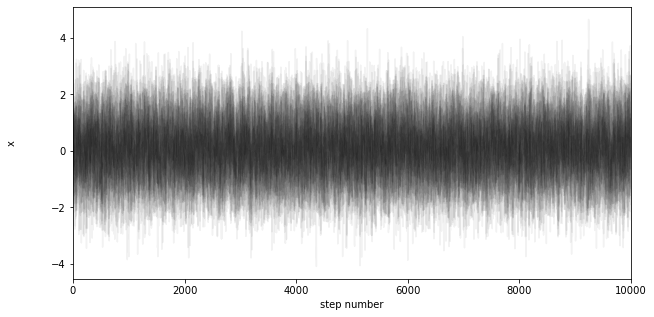

In [99]:
samples = sampler.get_chain()

labels = ['x']
fig, axes = plt.subplots(len(labels), figsize=(10, 5), sharex=True)
axes = np.atleast_1d(axes)
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.05)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()

In [100]:
E = (norm.cdf(5, loc=xdata, scale=1)-norm.cdf(-5, loc=xdata, scale=1))*1/10
E


0.09999993764325846

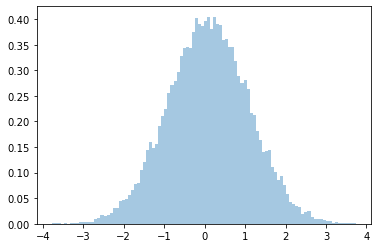

In [101]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
x = flat_samples[:, 0]
plt.hist(x, 100, density=True, histtype="stepfilled", alpha=0.4);

In [102]:
from tqdm import tqdm

mask = np.abs(x) < 3
x_sample = x[mask]
print(x_sample.shape)

(21065,)


In [103]:
vol = 2*3

Es = []
s = np.arange(1000, 20_000, 1000)

for S in tqdm(s):
    x_sample_s = x_sample[np.random.choice(len(x_sample), S, replace=False)]
    log_prob = -1*log_posterior(x_sample_s, xdata)
    log_max = np.max(log_prob)
    log_prob -= log_max
    log_arg = np.log(1/vol)+ log_max + np.log(np.sum(np.exp(log_prob))) - np.log(S)
    prob = np.exp(log_arg)
    E_sample = 1/prob
    Es.append(E_sample)

100%|██████████| 19/19 [00:26<00:00,  1.38s/it]


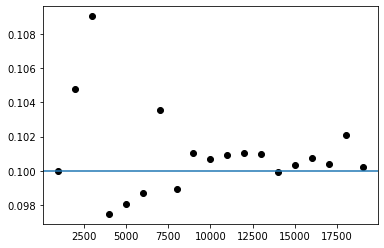

In [104]:
plt.scatter(s, Es, c='k')
plt.axhline(E)
plt.show()

# 2D

In [156]:
from scipy.stats import uniform

def log_prior(theta):
    x = theta[0]
    y = theta[1]
    prob_x = uniform.logpdf(x, loc=-5, scale=10)
    prob_y = uniform.logpdf(y, loc=-5, scale=10)
    return prob_x+prob_y 

def log_likelihood(theta, xdata, ydata):
    x = theta[0]
    y = theta[1]
    prob_x = norm.logpdf(xdata, loc=x, scale=1)
    prob_y = norm.logpdf(ydata, loc=y, scale=1)
    return prob_x + prob_y

def log_posterior(theta, xdata, ydata):
    return log_prior(theta) + log_likelihood(theta, xdata, ydata)

In [157]:
xdata = np.random.normal(loc=0, scale=1)
ydata = np.random.normal(loc=0, scale=1)
xdata, ydata

(0.3605501994613916, -0.44250582255239507)

In [162]:
nwalkers = 32
ndim = 2
x_0 = np.random.randn(nwalkers)
y_0 = np.random.randn(nwalkers)

p0 = np.array([x_0, y_0]).T
p0.shape

(32, 2)

In [164]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(xdata, ydata))
sampler.run_mcmc(p0, 10_000, progress=True);

  0%|          | 9/10000 [00:00<03:59, 41.63it/s]

100%|██████████| 10000/10000 [03:05<00:00, 53.99it/s]


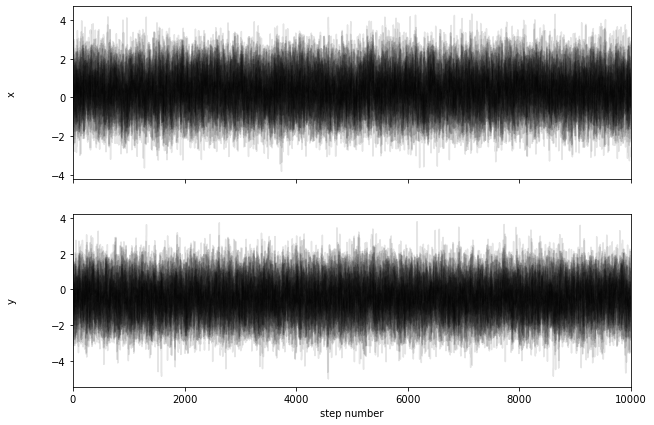

In [165]:
samples = sampler.get_chain()

labels = ['x', 'y']
fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.show()

In [168]:
flat_samples = sampler.get_chain(discard=100, thin=5, flat=True)
print(flat_samples.shape)

(63360, 2)


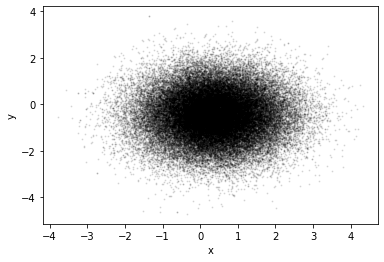

In [169]:
x = flat_samples[:, 0]
y = flat_samples[:, 1]

plt.scatter(x, y, s=1, c='k', alpha=0.1)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [170]:
Ex = (norm.cdf(5, loc=xdata, scale=1)-norm.cdf(-5, loc=xdata, scale=1))*1/10
Ey = (norm.cdf(5, loc=ydata, scale=1)-norm.cdf(-5, loc=ydata, scale=1))*1/10
E = Ex*Ey
E

0.009999955971859854

In [171]:
from tqdm import tqdm

mask = (np.abs(x) < 5)*(np.abs(y) < 3)
x_sample = x[mask]
y_sample = y[mask]

print(mask.sum())

62705


In [172]:
log_posterior

<function __main__.log_posterior(theta, xdata, ydata)>

In [179]:
vol = 2*3*2*3

Es = []
s = np.arange(1000, 60_000, 500)

for S in tqdm(s):
    x_sample_s = x_sample[np.random.choice(len(x_sample), S, replace=False)]
    y_sample_s = y_sample[np.random.choice(len(y_sample), S, replace=False)]
    theta = np.vstack([x_sample_s, y_sample_s])
    
    log_prob = -1*log_posterior(theta, xdata, ydata)
    log_max = np.max(log_prob)
    log_prob -= log_max
    log_arg = np.log(1/vol)+ log_max + np.log(np.sum(np.exp(log_prob))) - np.log(S)
    prob = np.exp(log_arg)
    E_sample = 1/prob
    Es.append(E_sample)

100%|██████████| 118/118 [00:01<00:00, 114.82it/s]


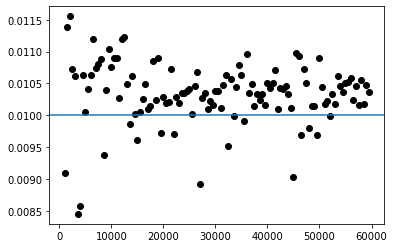

In [181]:
plt.scatter(s, Es, c='k')
plt.axhline(E)
plt.show()

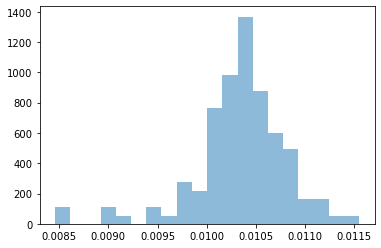

In [183]:
plt.hist(Es, bins=20, density=True, alpha=0.5, label='Es');